# DCSM Testing - Version 0.0.3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os, sys
import datetime as dt
import pandas as pd
from skimage import io
import torchvision
import torchvision.transforms as transforms
import random
import gc

# Settings:
NUM_EPOCHS = 5
BATCH_SIZE = 256
DIM = 300
NUM_WORKERS = 0
USE_TRAIN_AUGMENTATION = True
USE_TEST_AUGMENTATION = True
USE_LAZY_IMAGE_LOADING = False # Saves memory but is slower (image is read from harddrive on each request by dataloader instead of RAM)
FRACTION_OF_DATA_TO_USE = 1 # (based on probability) Use values lower than 1 when testing program
CLASSES_TO_USE = 10 # 10 is max
USE_CUDA = False

# Source folders
googleFolderPath = "C:\\food-training-images-database\\data\\food images\\google" # 0
sourceImageFolder = "/home/ubuntu/ImageData/SingleLabeledNew/ResizedAndAugmentedFinalData" # 1

sourceToUse = 1

# Data Preparation

To prepare for learning we first select the most recent subfolder from the google folder which coresponds to the most recent run of the image scraper tool so make sure the google folder contains at least one subfolder with image data in it. Next, the train and test images are loaded for each class.

In [2]:
def boolvalue_prob(probability):
    return random.random() < probability

if sourceToUse == 0:
    if not os.path.exists(googleFolderPath):
        raise ValueError('The specified google folder path does not exist.')

    # Get the subfolders of the google folder
    subfolders = [name for name in os.listdir(googleFolderPath) if os.path.isdir(os.path.join(googleFolderPath, name))]
    subfoldersDates = []
    for i in range(0, len(subfolders)):
        subfoldersDates.append(dt.datetime.strptime(subfolders[i], "%d%m%y_%H%M"))

    if len(subfolders) <= 0 or len(subfoldersDates) <= 0:
        raise ValueError('No image data found, run the image scaper tool.')

    # Sort the subfolders by date and select the most recent
    subfoldersDates.sort()
    databasePath = googleFolderPath + "/" + subfoldersDates[-1].strftime("%d%m%y_%H%M") + "/DL"
    # Just use this one please:
    databasePath = googleFolderPath + "/" + "291018_1724/DL"
    trainSetCSV = pd.read_csv(databasePath + "/train_clean.csv")
    testSetCSV = pd.read_csv(databasePath + "/test_clean.csv")
    trainSetPath = databasePath + "/training_images"
    testSetPath = databasePath + "/testing_images"

    # Read the different classnames from the train.csv file
    classnames = []
    for label in trainSetCSV.iloc[:, 2]:
        if label not in classnames:
            classnames.append(label)
            
elif sourceToUse == 1:
    databasePath = sourceImageFolder
    trainSetPath = databasePath + "/training_images"
    testSetPath = databasePath + "/testing_images"
    classnames = [name for name in os.listdir(trainSetPath) if os.path.isdir(os.path.join(trainSetPath, name))]
    classnames = classnames[0:CLASSES_TO_USE]
else:
    raise ValueError('Pick a valid source folder to use.')
    
if not os.path.exists(databasePath):
    raise ValueError('This database path does not exist: {0}'.format(databasePath))
    
if not os.path.exists(trainSetPath):
    raise ValueError('This training set path does not exist: {0}'.format(trainSetPath))
    
if not os.path.exists(testSetPath):
    raise ValueError('This test set path does not exist: {0}'.format(testSetPath))
 

if USE_LAZY_IMAGE_LOADING:
    print("Preparing images using lazy image loading...\n")
else:
    print("Preparing images using standard image loading...\n")

loadErrors_train = 0
loadErrors_test = 0
loadSkipped_train = 0
loadSkipped_test = 0
augmentedTrainImages = 0
augmentedTestImages = 0

train_images_paths = []
train_images = []
train_classLabels = []
for classLabel, classname in enumerate(classnames):
    if sourceToUse == 0:
        imgDir = trainSetPath + "/" + str(classLabel)
    else:
        imgDir = trainSetPath + "/" + classname
    for i, imgName in enumerate(os.listdir(imgDir)):
        if boolvalue_prob(FRACTION_OF_DATA_TO_USE):
            imgPath = imgDir + "/" + imgName
            isAugmented = False
            if "_FLIPPEDLEFTRIGHT" in imgPath or "_ROTATED90" in imgPath or "_OVEREXPOSED" in imgPath or "_UNDEREXPOSED" in imgPath or "_BLURED" in imgPath:
                augmentedTrainImages += 1
                isAugmented = True

            if USE_TRAIN_AUGMENTATION or not isAugmented:
                try: 
                    img = Image.open(imgPath)
                    if img.size != (DIM, DIM):
                        raise ValueError('Image is wrong size: ({0}, {1}) should be ({2}, {3})'.format(img.size[0], img.size[1], DIM, DIM))
                    if img.mode != "RGB":
                        raise ValueError("Image is not RGB: '{0}' should be 'RGB'".format(img.mode))
                    if not USE_LAZY_IMAGE_LOADING:
                        train_images.append(img.copy())
                    else:
                        train_images.append(imgPath)
                    train_images_paths.append(imgPath)
                    train_classLabels.append(classLabel)
                    img.close()
                except:
                    loadErrors_train += 1
            else:
                augmentedTrainImages = 0
        else:
            loadSkipped_train += 1


test_images_paths = []
test_images = []
test_classLabels = []
for classLabel, classname in enumerate(classnames):
    if sourceToUse == 0:
        imgDir = testSetPath + "/" + str(classLabel)
    else:
        imgDir = testSetPath + "/" + classname
    for i, imgName in enumerate(os.listdir(imgDir)):
        if boolvalue_prob(FRACTION_OF_DATA_TO_USE):
            imgPath = imgDir + "/" + imgName
            isAugmented = False
            if "_FLIPPEDLEFTRIGHT" in imgPath or "_ROTATED90" in imgPath or "_OVEREXPOSED" in imgPath or "_UNDEREXPOSED" in imgPath or "_BLURED" in imgPath:
                augmentedTestImages += 1
                isAugmented = True

            if USE_TEST_AUGMENTATION or not isAugmented:
                try: 
                    img = Image.open(imgPath)
                    if img.size != (DIM, DIM):
                        raise ValueError('Image is wrong size: ({0}, {1}) should be ({2}, {3})'.format(img.size[0], img.size[1], DIM, DIM))
                    if img.mode != "RGB":
                        raise ValueError("Image is not RGB: '{0}' should be 'RGB'".format(img.mode))
                    if not USE_LAZY_IMAGE_LOADING:
                        test_images.append(img.copy())
                    else:
                        test_images.append(imgPath)
                    test_images_paths.append(imgPath)
                    test_classLabels.append(classLabel)
                    img.close()
                except:
                    loadErrors_test += 1
            else:
                augmentedTestImages = 0
        else:
            loadSkipped_test += 1

# Print data summary    
print("Data summary:\n\nTraining data path: {0}\nTesting data path: {1}\n\nNumber of classes: {2}\nClass names: {3}\n\nUseable training images in total: {4}\nUseable augmented training images in total: {5}\n\nUseable test images in total: {6}\nUseable augmented test images in total: {7}\n\nTraining data errors: {8}\nTesting data errors: {9}".format(
        trainSetPath,
        testSetPath,
        len(classnames), 
        classnames, 
        len(train_images),
        augmentedTrainImages,
        len(test_images),
        augmentedTestImages,
        loadErrors_train,
        loadErrors_test))

# Check for errors and warnings
if len(train_images) < 1:
    raise ValueError("\nFailed to load any training images.")

if len(test_images) < 1:
    raise ValueError("\nFailed to load any testing images.")

if loadErrors_train > 0:
    print("\nWARNING: There seems to be {0} cases where a path did not point to a readable RGB image in the training_images folder. This is likely do to bugs in the scraper tool. Make sure all paths points to a readable RGB image of size ({1}, {2}) or ignore the errors and continue with only {3} training images.".format(loadErrors_train, DIM, DIM, len(train_images)))
else:
    print("\nSuccesfully loaded training images with no errors.")

if loadErrors_test > 0:
    print("\nWARNING: There seems to be {0} cases where a path did not point to a readable RGB image in the testing_images folder. This is likely do to bugs in the scraper tool. Make sure all paths points to a readable RGB image of size ({1}, {2}) or ignore the errors and continue with only {3} testing images.".format(loadErrors_test, DIM, DIM, len(test_images)))
else:
    print("\nSuccesfully loaded testing images with no errors.") 

    


Preparing images using standard image loading...

Data summary:

Training data path: /home/ubuntu/ImageData/SingleLabeledNew/ResizedAndAugmentedFinalData/training_images
Testing data path: /home/ubuntu/ImageData/SingleLabeledNew/ResizedAndAugmentedFinalData/testing_images

Number of classes: 10
Class names: ['plain spaghetti', 'slice of bread', 'fried egg', 'chopped lettuce', 'glass of milk', 'boiled potatoes', 'boiled peas', 'plain rice', 'meatballs', 'glass of water']

Useable training images in total: 8647
Useable augmented training images in total: 1549

Useable test images in total: 2158
Useable augmented test images in total: 390

Training data errors: 39
Testing data errors: 10




An efficient data generation scheme is crucial to leverage the full potential of your CPU (or GPU) during the training process so that the data generation process does not become a bottleneck. When the training and testing images has been loaded in the above, we can set up the dataloaders. For data loading, we implement a class that inherits the highly optimized Dataset type, and defines the data reading functions and data access functions as well as transforms that we will like to apply.

In [3]:
class FoodDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasetType, transform):
        
        if datasetType == "Training":
            self.images = train_images # With lazy image loading this will only be a list of paths
            self.labels = train_classLabels
        elif datasetType == "Testing":
            self.images = test_images # With lazy image loading this will only be a list of paths
            self.labels = test_classLabels
        else:
            raise ValueError("datasetType should be either 'Training' or 'Testing'.")
            
        self.transform = transform;
        
    def __len__(self):
        return len(self.images);
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if USE_LAZY_IMAGE_LOADING:
            imageTemp = Image.open(image)
            image = imageTemp.copy()
            imageTemp.close()
            
        image = self.transform(image)
        label = self.labels[idx]
        
        return {"image": image, "label": label};
    
    def getRandomIndexByLabel(self, labelx):
        labelsList = [i for i, x in enumerate(self.labels) if x == labelx]
        return random.sample(labelsList, 1)[0]
    
# CUDA for PyTorch
use_cuda = torch.cuda.is_available() and USE_CUDA
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device: {0}".format(device))

# Parameters
print("Using batch size: {0}".format(BATCH_SIZE))
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': NUM_WORKERS}
max_epochs = NUM_EPOCHS 

# Transformation
#transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform=transforms.Compose([transforms.ToTensor()])

# Data sets and loaders
training_set = FoodDataset(datasetType="Training", transform=transform)
training_dataloader = torch.utils.data.DataLoader(training_set, **params)

test_set = FoodDataset(datasetType="Testing", transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, **params)


Using device: cpu
Using batch size: 256


We can now easely get a single sample by index or use the dataloaders for batch training. A sample will consist of two objects: an image and a label like so:

The image looks like this when shown:


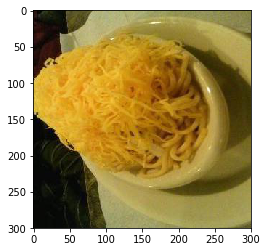

Its class label is '0' which is 'plain spaghetti'


In [4]:
# Get the first sample from the training set dataloader
sample = training_set[0]
sample_image = sample["image"]
sample_label = sample["label"]
sample_label_name = classnames[sample_label]

# Plot the image and print its class label and the name of its class label
# When plotting an image we always swap the axis so that the image is displayed correctly
print("The image looks like this when shown:")
sample_image = sample_image.transpose(0, 2) # Swap axis 0 and 2
sample_image = sample_image.transpose(0, 1) # Swap axis 0 and 1
plt.imshow(sample_image)
plt.show()
print("Its class label is '{0}' which is '{1}'".format(sample_label, sample_label_name))

Let's print out a few images from each class to make sure everything is correctly set up and that the correct class names are associated with the correct images.

Sampling images from training set...


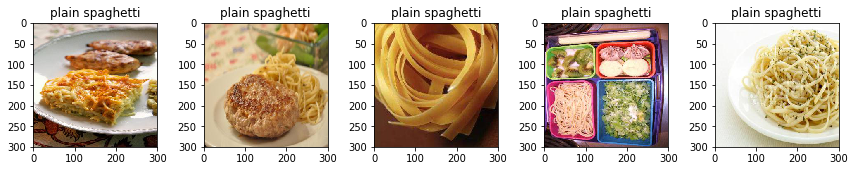

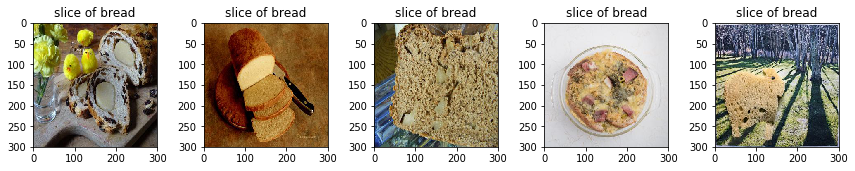

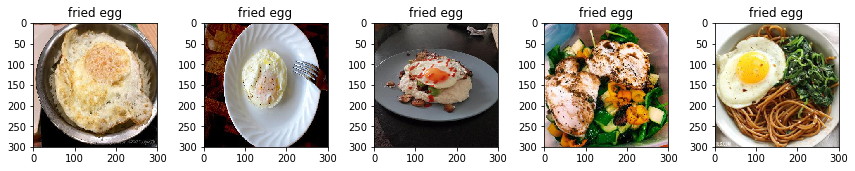

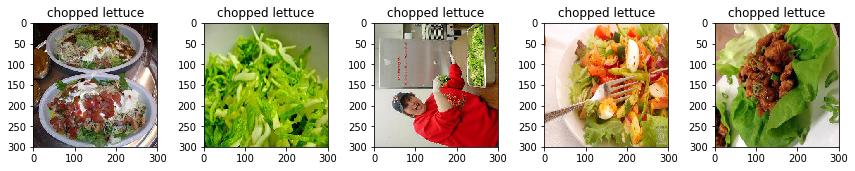

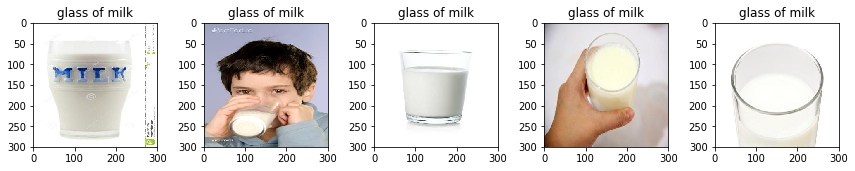

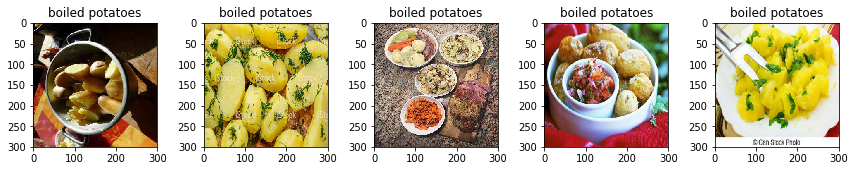

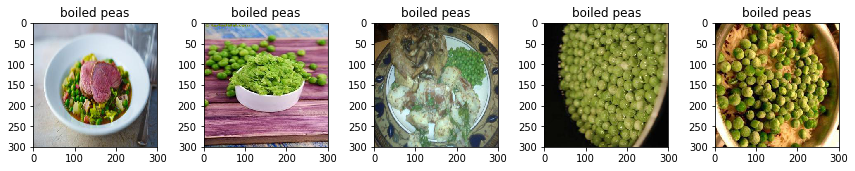

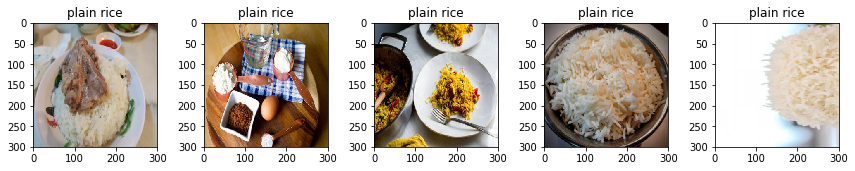

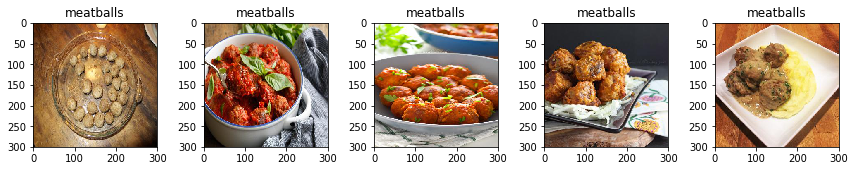

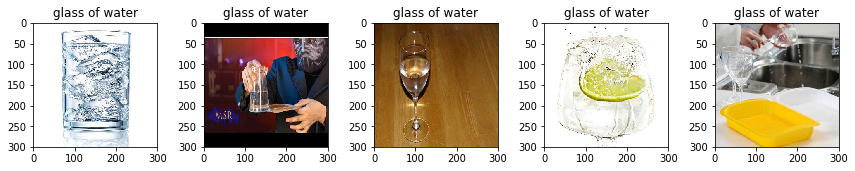

In [5]:
numberOfImagesToShowPerClass = 5
showAxis = True

try:
    print("Sampling images from training set...")
    for i in range(0, len(classnames)):
        plt.figure(figsize=(12,30))
        for k in range(0, numberOfImagesToShowPerClass):
            j = training_set.getRandomIndexByLabel(i)
            imgSample = training_set[j]["image"]
            imgSample = imgSample.transpose(0, 2) # Swap axis 0 and 2
            imgSample = imgSample.transpose(0, 1) # Swap axis 0 and 1
            ax = plt.subplot(len(classnames), numberOfImagesToShowPerClass, k+1)
            plt.tight_layout()
            ax.set_title("{0}".format(classnames[i]))
            if not showAxis:
                ax.axis('off')
            plt.imshow(imgSample)

    plt.show()
except:
    print("This failed.")

# Define a Neural Network

We define a neural network.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, Conv3d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, max_pool2d

# hyperameters of the model
channels = training_set[0]["image"].shape[0]
height = training_set[0]["image"].shape[1]
width = training_set[0]["image"].shape[2]
print("Channels = {0}\nHeight = {1}\nWidth = {2}".format(channels, height, width))

num_filters_conv1 = 64
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 2 # [stride_height, stride_width]
padding_conv1 = 0
dropout1 = 0.5

kernel_size_maxpool1 = 2
padding_maxpool1 = 0
stride_maxpool1 = 2

num_filters_conv2 = 128
kernel_size_conv2 = 4 # [height, width]
stride_conv2 = 2 # [stride_height, stride_width]
padding_conv2 = 0
dropout2 = 0.

kernel_size_maxpool2 = 2
padding_maxpool2 = 0
stride_maxpool2 = 2

num_filters_conv3 = 512
kernel_size_conv3 = 4 # [height, width]
stride_conv3 = 2 # [stride_height, stride_width]
padding_conv3 = 0
dropout3 = 0.5

kernel_size_maxpool3 = 2
padding_maxpool3 = 0
stride_maxpool3 = 2

num_l1 = 2000
num_l2 = 200

netSummary = ""

def compute_conv_dim(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.netSummary = ""
        self.num_classes = num_classes
        
        # First 2D convolutional layer
        self.conv_1 = Conv2d(in_channels=channels, 
                             out_channels=num_filters_conv1, 
                             kernel_size=kernel_size_conv1, 
                             stride=stride_conv1)
        self.conv1_out_height = compute_conv_dim(height, kernel_size_conv1, padding_conv1, stride_conv1)
        self.conv1_out_width = compute_conv_dim(width, kernel_size_conv1, padding_conv1, stride_conv1)
        #self.zeroPad_conv1 = nn.ZeroPad2d(padding_conv1)
        self.maxPool2d_1 = nn.MaxPool2d(kernel_size=kernel_size_maxpool1, padding=padding_maxpool1, stride=stride_maxpool1)
        #self.dropout_1 = nn.Dropout2d(p=dropout1)
        self.batchnorm_1 = nn.BatchNorm2d(num_filters_conv1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_conv1 = nn.ReLU()
        
        self.netSummary += "\nConv1 values:\n"
        self.netSummary += "    in channels: {0}\n".format(channels)
        self.netSummary += "    out channels: {0}\n".format(num_filters_conv1)
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_conv1)
        self.netSummary += "    stride: {0}\n".format(stride_conv1)
        self.netSummary += "    out height: {0}\n".format(self.conv1_out_height)
        self.netSummary += "    out width: {0}\n".format(self.conv1_out_width)
        self.netSummary += "\nMax1 values:\n"
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_maxpool1)
        self.netSummary += "    padding: {0}\n".format(padding_maxpool1)
        self.netSummary += "    stride: {0}\n".format(stride_maxpool1)
        
        # Second 2D convolutional layer
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2, 
                             kernel_size=kernel_size_conv2, 
                             stride=stride_conv2)
        self.conv2_out_height = compute_conv_dim(self.conv1_out_height, kernel_size_conv2, padding_conv2, stride_conv2)
        self.conv2_out_width = compute_conv_dim(self.conv1_out_width, kernel_size_conv2, padding_conv2, stride_conv2)
        #self.zeroPad_conv2 = nn.ZeroPad2d(padding_conv2)
        self.maxPool2d_2 = nn.MaxPool2d(kernel_size=kernel_size_maxpool2, padding=padding_maxpool2, stride=stride_maxpool2)
        #self.dropout_2 = nn.Dropout2d(p=dropout2)
        self.batchnorm_2 = nn.BatchNorm2d(num_filters_conv2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_conv2 = nn.ReLU()
        
        self.netSummary += "\nConv2 values:\n"
        self.netSummary += "    in channels: {0}\n".format(num_filters_conv1)
        self.netSummary += "    out channels: {0}\n".format(num_filters_conv2)
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_conv2)
        self.netSummary += "    stride: {0}\n".format(stride_conv2)
        self.netSummary += "    out height: {0}\n".format(self.conv2_out_height)
        self.netSummary += "    out width: {0}\n".format(self.conv2_out_width)
        self.netSummary += "\nMax2 values:\n"
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_maxpool2)
        self.netSummary += "    padding: {0}\n".format(padding_maxpool2)
        self.netSummary += "    stride: {0}\n".format(stride_maxpool2)
        
        # Third 2D convolutional layer
        self.conv_3 = Conv2d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3, 
                             kernel_size=kernel_size_conv3, 
                             stride=stride_conv3)
        self.conv3_out_height = compute_conv_dim(self.conv2_out_height, kernel_size_conv3, padding_conv3, stride_conv3)
        self.conv3_out_width = compute_conv_dim(self.conv2_out_width, kernel_size_conv3, padding_conv3, stride_conv3)
        #self.zeroPad_conv2 = nn.ZeroPad2d(padding_conv2)
        self.maxPool2d_3 = nn.MaxPool2d(kernel_size=kernel_size_maxpool3, padding=padding_maxpool3, stride=stride_maxpool3)
        #self.dropout_3 = nn.Dropout2d(p=dropout3)
        self.batchnorm_3 = nn.BatchNorm2d(num_filters_conv3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_conv3 = nn.ReLU()
        
        self.netSummary += "\nConv3 values:\n"
        self.netSummary += "    in channels: {0}\n".format(num_filters_conv2)
        self.netSummary += "    out channels: {0}\n".format(num_filters_conv3)
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_conv3)
        self.netSummary += "    stride: {0}\n".format(stride_conv3)
        self.netSummary += "    out height: {0}\n".format(self.conv3_out_height)
        self.netSummary += "    out width: {0}\n".format(self.conv3_out_width)
        self.netSummary += "\nMax3 values:\n"
        self.netSummary += "    kernelsize: {0}\n".format(kernel_size_maxpool3)
        self.netSummary += "    padding: {0}\n".format(padding_maxpool3)
        self.netSummary += "    stride: {0}\n".format(stride_maxpool3)
        
        self.l1_in_features = 8192
        
        self.l_1 = Linear(in_features=self.l1_in_features, out_features=num_l1, bias=True)
        self.relu_l_1 = nn.ReLU()
        
        self.l_2 = Linear(in_features=num_l1, out_features=num_l2, bias=True)
        self.relu_l_2 = nn.ReLU()
        
        self.l_out = Linear(in_features=num_l2, out_features=num_classes, bias=True)

    def forward(self, x):        
        x = self.conv_1(x)
        x = self.relu_conv1(x)
        x = self.maxPool2d_1(x)
        x = self.batchnorm_1(x)
        #x = self.dropout_1(x)
        #x = self.relu_conv1(x)
        
        x = self.conv_2(x)
        x = self.relu_conv2(x)
        x = self.maxPool2d_2(x)
        x = self.batchnorm_2(x)
        #x = self.dropout_2(x)
        #x = self.relu_conv2(x)
        
        x = self.conv_3(x)
        x = self.relu_conv3(x)
        x = self.maxPool2d_3(x)
        x = self.batchnorm_3(x)
        #x = self.dropout_3(x)
        #x = self.relu_conv3(x)

        x = x.view(x.size(0),-1)
        
        x = self.relu_l_1(self.l_1(x))
        x = self.relu_l_2(self.l_2(x))
        x = self.l_out(x)
        #x = softmax(x, dim=1)
        return x, 0
    

net = Net(len(classnames))
if use_cuda:
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)
print(net.netSummary)

Channels = 3
Height = 300
Width = 300
Net(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (maxPool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_conv1): ReLU()
  (conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (maxPool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_conv2): ReLU()
  (conv_3): Conv2d(128, 512, kernel_size=(4, 4), stride=(2, 2))
  (maxPool2d_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_conv3): ReLU()
  (l_1): Linear(in_features=8192, out_features=2000, bias=True)
  (relu_l_1): ReLU()
  (l_2): Linear(in_features=2000, out_features

# Define Loss Function and Optimizer

We define a loss function and an optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001,  weight_decay=1e-6)

# Train the Network

Now we train the network

In [ ]:
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import math

# NUM_EPOCHS # BATCHSIZE # Iterations
#     3      #    32     #    3900
#
#
            
iterations = math.ceil((len(train_images)/BATCH_SIZE)*NUM_EPOCHS)
        
print("Total iterations to do: {0}".format(iterations))


print('Training. Please wait...')
icounter = 0
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_dataloader):
        icounter += 1
        #try:
        # get the inputs
        #print(data)
        inputs, labels = data["image"], data["label"]

        # wrap them in Variable
        if use_cuda:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.data.item()
        #if i % 10 == 9:    # print every 10 mini-batches
        print('epoch: %d/%d, total iteration %d/%d | loss: %.5f' % (epoch + 1, NUM_EPOCHS, icounter, iterations, running_loss / 1000))
        running_loss = 0.0
        #except:
        #    print("This one failed.")
        gc.collect()

print('Finished Training')


Total iterations to do: 169
Training. Please wait...
epoch: 1/5, total iteration 1/169 | loss: 0.00231
epoch: 1/5, total iteration 2/169 | loss: 0.00225
epoch: 1/5, total iteration 3/169 | loss: 0.00219
epoch: 1/5, total iteration 4/169 | loss: 0.00215
epoch: 1/5, total iteration 5/169 | loss: 0.00209
epoch: 1/5, total iteration 6/169 | loss: 0.00203
epoch: 1/5, total iteration 7/169 | loss: 0.00199
epoch: 1/5, total iteration 8/169 | loss: 0.00194
epoch: 1/5, total iteration 9/169 | loss: 0.00187
epoch: 1/5, total iteration 10/169 | loss: 0.00187
epoch: 1/5, total iteration 11/169 | loss: 0.00183
epoch: 1/5, total iteration 12/169 | loss: 0.00178
epoch: 1/5, total iteration 13/169 | loss: 0.00178
epoch: 1/5, total iteration 14/169 | loss: 0.00174
epoch: 1/5, total iteration 15/169 | loss: 0.00175
epoch: 1/5, total iteration 16/169 | loss: 0.00159
epoch: 1/5, total iteration 17/169 | loss: 0.00169
epoch: 1/5, total iteration 18/169 | loss: 0.00158
epoch: 1/5, total iteration 19/169 | l

epoch: 5/5, total iteration 160/169 | loss: 0.00058


# Test the Network

In [ ]:
correct = 0
total = 0

print('Testing. Please wait...')

for data in test_dataloader:
    #print("Getting test batch...")
    images, labels = data["image"], data["label"]
    
    #print("Wrapping images in variables...")
    if use_cuda:
        images = Variable(images.cuda())
    else:
        images = Variable(images)
        
    #print("Feeding them to network...")
    outputs, _ = net(images)
        
    #print("Storing results...")
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    if use_cuda:
        correct += (predicted == labels.cuda()).sum()
    else:
        correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(test_set), 100 * correct / total))

print("(Random guessing would be {:4.2f} % on average)\n".format(100/len(classnames)))
    
class_total = list(0. for i in range(len(classnames)))
class_correct = list(0. for i in range(len(classnames)))

for data in test_dataloader:
    images, labels = data["image"], data["label"]
    if use_cuda:
        outputs, _ = net(Variable(images.cuda()))
    else:
        outputs, _ = net(Variable(images))
        
    _, predicted = torch.max(outputs.data, 1)
    
    if use_cuda:
        c = (predicted == labels.cuda()).squeeze()
    else:
        c = (predicted == labels).squeeze()

    try:
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].cpu().numpy()
            class_total[label] += 1
    except:
        print("c error ignored\n")

for i in range(len(classnames)):
    print('Accuracy of {0:10s}: {1} of {2} correct = {3:5.2f} %'.format(
        classnames[i], int(class_correct[i]), int(class_total[i]), 100 * class_correct[i] / class_total[i]))

Write parameters and test results to a file:

In [ ]:
dataPath = "/home/ubuntu/02456_HediaDeepLearningProject/DeepLearning/Michael/Logs/SimpleCNN/Training.txt"
now = dt.datetime.now()

datafile = open(dataPath, "a")
datafile.write("\n\n\n***** TRAINING DONE: {0} *****\n\n".format(str(now)))

datafile.write("Data summary:\nTraining data path: {0}\nTesting data path: {1}\nNumber of classes: {2}\nClass names: {3}\nUseable training images in total: {4}\nUseable augmented training images in total: {5}\nUseable test images in total: {6}\nUseable augmented test images in total: {7}\nTraining data errors: {8}\nTesting data errors: {9}".format(
        trainSetPath,
        testSetPath,
        len(classnames), 
        classnames, 
        len(train_images),
        augmentedTrainImages,
        len(test_images),
        augmentedTestImages,
        loadErrors_train,
        loadErrors_test))

datafile.write("\n\nSettings:\nNUM_EPOCHS: {0}\nBATCH_SIZE: {1}\nDIM: {2}\nNUM_WORKERS: {3}\nUSE_TRAIN_AUGMENTATION: {4}\nUSE_TEST_AUGMENTATION: {5}\nUSE_LAZY_IMAGE_LOADING: {6}\nFRACTION_OF_DATA_TO_USE: {7}\nCLASSES_TO_USE: {8}\nUSE_CUDA: {9}".format(
        NUM_EPOCHS,
        BATCH_SIZE,
        DIM,
        NUM_WORKERS,
        USE_TRAIN_AUGMENTATION,
        USE_TEST_AUGMENTATION,
        USE_LAZY_IMAGE_LOADING,
        FRACTION_OF_DATA_TO_USE,
        CLASSES_TO_USE,
        USE_CUDA))

datafile.write("\n\nNetwork Summary: \n{0}".format(net.netSummary))
datafile.write("\n\nNetwork: \n{0}".format(net))

datafile.write("\n\nTest results:\n")

datafile.write('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(test_set), 100 * correct / total))

datafile.write("(Random guessing would be {:4.2f} % on average)\n".format(100/len(classnames)))

for i in range(len(classnames)):
    datafile.write('    Accuracy of {0:10s}: {1} of {2} correct = {3:5.2f} %\n'.format(
        classnames[i], int(class_correct[i]), int(class_total[i]), 100 * class_correct[i] / class_total[i]))

datafile.write("\n**************************************************\n".format(str(now)))
datafile.close()

print("DONE")